# Set-up

In [1]:
import os

script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)

os.chdir(script_dir)  # Change working directory to script directory

## Importing modules

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/missionbio/mosaic/io.py:47: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



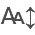

In [2]:
# Import generic libraries
import os
import copy
import random
import multiprocessing
import scanpy as sc
import numpy as nps
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn.metrics
from scipy.stats import ranksums
from scipy.cluster.hierarchy import linkage, leaves_list
from statsmodels.stats.multitest import multipletests
import espressopro as ep

# Import mosaic libraries
import missionbio.mosaic as ms

# Get the number of detectable CPU cores
num_cores = multiprocessing.cpu_count()

# Subtract one from the number of cores
num_cores_to_use = max(1, num_cores - 1)

# Import graph_objects from the plotly package to display figures when saving the notebook as an HTML
import plotly.graph_objects as go

# Import additional packages for specific visuals
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
from itables import init_notebook_mode, show
from itables.sample_dfs import get_dict_of_test_dfs
import itables.options as opt

# Defining itables options
dict_of_test_dfs = get_dict_of_test_dfs()
init_notebook_mode(all_interactive=True)
opt.lengthMenu = [5, 10, 20, 50, 100, 200, 500]
opt.maxBytes = 0
opt.maxColumns = 0
opt.classes = ["display", "nowrap"]

# Other useful packages for downstream cluster analyses
import pandas as pd

# Note: when exporting the notebook as an HTML, plots that use the "go.Figure(fig)" command are saved

In [3]:
pip list

Package                   Version
------------------------- --------------
absl-py                   2.3.1
aiofiles                  24.1.0
aiohappyeyeballs          2.6.1
aiohttp                   3.12.15
aiosignal                 1.4.0
anndata                   0.11.4
annoy                     1.17.3
anyio                     4.10.0
anywidget                 0.9.18
appnope                   0.1.4
argon2-cffi               25.1.0
argon2-cffi-bindings      25.1.0
array-api-compat          1.12.0
arrow                     1.3.0
asttokens                 3.0.0
async-timeout             5.0.1
attrs                     25.3.0
beautifulsoup4            4.13.4
bleach                    6.2.0
Brotli                    1.1.0
cached-property           1.5.2
cellhint                  1.0.0
certifi                   2025.8.3
cffi                      1.17.1
charset-normalizer        3.4.2
chex                      0.1.90
choreographer             1.0.9
chrov                     0.0.3
click       

PYTHONHASHSEED was set as envinronmental variable to 0 as follows:
    
conda env config vars set PYTHONHASHSEED=0

In [4]:
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)

In [5]:
def ensure_pythonhashseed(seed=0):
    current_seed = os.environ.get("PYTHONHASHSEED")

    seed = str(seed)
    if current_seed is None or current_seed != seed:
        print(f'Setting PYTHONHASHSEED="{seed}"')
        os.environ["PYTHONHASHSEED"] = seed
        # restart the current process
        os.execl(sys.executable, sys.executable, *sys.argv)

In [6]:
import random

hash = random.getrandbits(128)

print("hash value: %032x" % hash)

hash value: bdd640fb06671ad11c80317fa3b1799d


## Defining paths

In [7]:
figures_path = os.path.join(parent_dir, "Figures")

# Load Data

In [8]:
PBMC_samples = ms.load_example_dataset(path="Multisample PBMC", single=False)

          0/2: 

            0%: 

            0%: 

In [9]:
PBMC_HD01 = PBMC_samples.samples[0]
PBMC_HD02 = PBMC_samples.samples[1]

# <b> Data Overview </b>

In [10]:
# Summary of Protein assay 
print("\'sample.protein\':", PBMC_HD01.protein, '\n')
print("\'row_attrs\':", "\n\t", list(PBMC_HD01.protein.row_attrs.keys()), '\n')
print("\'col_attrs\':", "\n\t", list(PBMC_HD01.protein.col_attrs.keys()), '\n')
print("\'layers\':", "\n\t", list(PBMC_HD01.protein.layers.keys()), '\n')
print("\'metadata\':", "\n")
for i in list(PBMC_HD01.protein.metadata.keys()):
    print("\t", i, ": ", PBMC_HD01.protein.metadata[i], sep="")

'sample.protein': protein_read_counts assay with 3 layers, 1943 rows and 45 columns 

'row_attrs': 
	 ['barcode', 'label', 'sample_name', 'umap'] 

'col_attrs': 
	 ['antibody_id', 'id'] 

'layers': 
	 ['CLR', 'NSP', 'read_counts'] 

'metadata': 

	sample_name: [['Sample 1']]
	n_antibodies: [45]
	n_bases_r1: [16832308995]
	n_bases_r1_q30: [16063986778]
	n_bases_r2: [16832308995]
	n_bases_r2_q30: [15937132217]
	n_candidate_barcodes: [130665]
	n_cell_barcode_bases: [5579297356]
	n_cell_barcode_bases_q30: [5468052924]
	n_read_pairs: [111472245]
	n_read_pairs_after_candidate_barcode_filtering: [98747536]
	n_read_pairs_trimmed: [110594191]
	n_read_pairs_valid_ab_barcodes: [98988533]
	n_read_pairs_valid_cell_barcodes: [106678038]
	panel_name: ['ab_launch_45plex']
	pipeline_version: ['2.0.1']


In [11]:
# Summary of Protein assay 
print("\'sample.protein\':", PBMC_HD02.protein, '\n')
print("\'row_attrs\':", "\n\t", list(PBMC_HD02.protein.row_attrs.keys()), '\n')
print("\'col_attrs\':", "\n\t", list(PBMC_HD02.protein.col_attrs.keys()), '\n')
print("\'layers\':", "\n\t", list(PBMC_HD02.protein.layers.keys()), '\n')
print("\'metadata\':", "\n")
for i in list(PBMC_HD02.protein.metadata.keys()):
    print("\t", i, ": ", PBMC_HD02.protein.metadata[i], sep="")

'sample.protein': protein_read_counts assay with 3 layers, 1808 rows and 45 columns 

'row_attrs': 
	 ['barcode', 'label', 'sample_name', 'umap'] 

'col_attrs': 
	 ['antibody_id', 'id'] 

'layers': 
	 ['CLR', 'NSP', 'read_counts'] 

'metadata': 

	sample_name: [['Sample 2']]
	n_antibodies: [45]
	n_bases_r1: [16832308995]
	n_bases_r1_q30: [16063986778]
	n_bases_r2: [16832308995]
	n_bases_r2_q30: [15937132217]
	n_candidate_barcodes: [130665]
	n_cell_barcode_bases: [5579297356]
	n_cell_barcode_bases_q30: [5468052924]
	n_read_pairs: [111472245]
	n_read_pairs_after_candidate_barcode_filtering: [98747536]
	n_read_pairs_trimmed: [110594191]
	n_read_pairs_valid_ab_barcodes: [98988533]
	n_read_pairs_valid_cell_barcodes: [106678038]
	panel_name: ['ab_launch_45plex']
	pipeline_version: ['2.0.1']


## <b> Protein Analysis </b>

### Filtering non-informative proteins

In [12]:
PBMC_HD01.protein = PBMC_HD01.protein.drop(['IgG1', 'IgG2a', 'IgG2b'])
PBMC_HD02.protein = PBMC_HD02.protein.drop(['IgG1', 'IgG2a', 'IgG2b'])

### Normalisation

In [13]:
ep.Normalise_protein_data(PBMC_HD01)
ep.Scale_protein_data(PBMC_HD01)

ep.Normalise_protein_data(PBMC_HD02)
ep.Scale_protein_data(PBMC_HD02)

Fitting GMMs:   0%|          | 0/1943 [00:00<?, ?it/s]

[Normalise_protein_data] Applied MissionBio NSP normalization
[Scale_protein_data] Scaled 'Normalized_reads' -> saved as 'Scaled_reads'


Fitting GMMs:   0%|          | 0/1808 [00:00<?, ?it/s]

[Normalise_protein_data] Applied MissionBio NSP normalization
[Scale_protein_data] Scaled 'Normalized_reads' -> saved as 'Scaled_reads'


### Dimensionality reduction

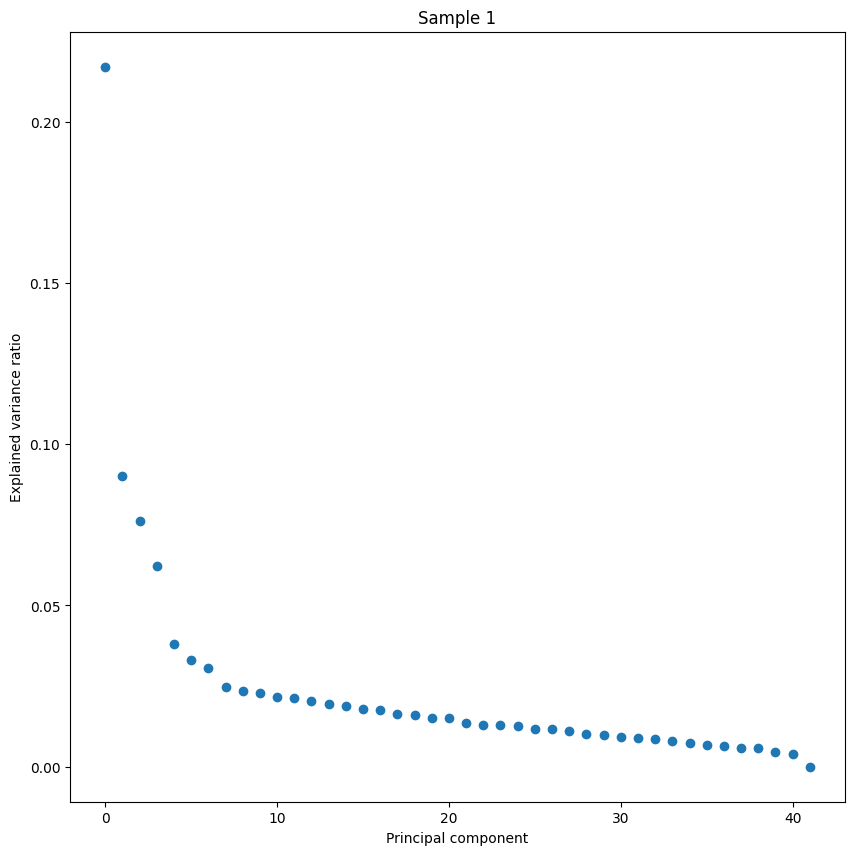

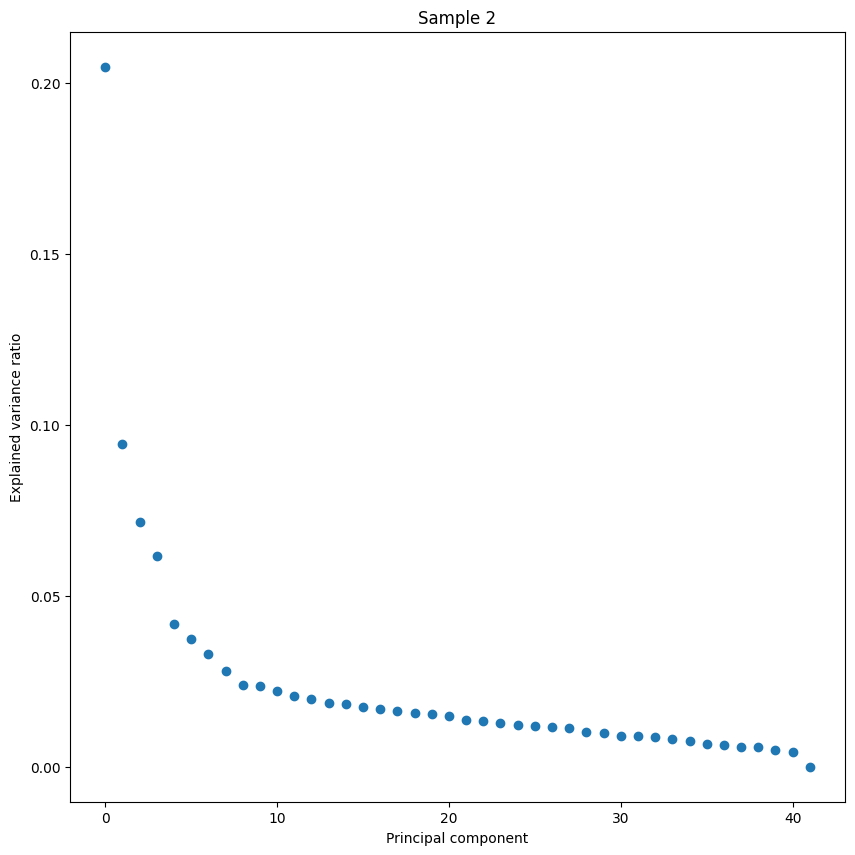

In [14]:
PBMC_HD01.protein.run_pca(attribute='Scaled_reads', components=45,show_plot=True, random_state=42, svd_solver='randomized')
PBMC_HD02.protein.run_pca(attribute='Scaled_reads', components=45,show_plot=True, random_state=42, svd_solver='randomized')

In [15]:
PBMC_HD01.protein.run_pca(attribute='Scaled_reads', components=8, show_plot=False, random_state=42, svd_solver='randomized')
PBMC_HD02.protein.run_pca(attribute='Scaled_reads', components=8, show_plot=False, random_state=42, svd_solver='randomized')

In [16]:
PBMC_HD01.protein.run_umap(attribute='pca', random_state=42, n_neighbors=50, min_dist=0.1, spread=8, n_components=2)
PBMC_HD02.protein.run_umap(attribute='pca', random_state=42, n_neighbors=50, min_dist=0.1, spread=8, n_components=2)

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/umap/umap_.py:1394: RuntimeWarning:

divide by zero encountered in power

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/umap/umap_.py:1394: RuntimeWarning:

divide by zero encountered in power

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jo

### Clustering

In [17]:
PBMC_HD01.protein.cluster(attribute='umap', method='graph-community', k=8, random_state=42) 
PBMC_HD02.protein.cluster(attribute='umap', method='graph-community', k=8, random_state=42)     

  0%|          | 0/15544 [00:00<?, ?it/s]

Number of clusters found: 45.
Modularity: 0.951


  0%|          | 0/14464 [00:00<?, ?it/s]

Number of clusters found: 41.
Modularity: 0.947


# EspressoPro

## Generate predictions

In [18]:
PBMC_HD01.protein.shape


(1943, 42)

In [19]:
PBMC_HD02.protein.shape


(1808, 42)

In [20]:
from pathlib import Path
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

p = Path("/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906/Luecken/Models/Broad_Immature/Broad_Immature_bundle.joblib")
bundle = joblib.load(p)

# 1) Top-level scaler in the bundle?
print("Top-level 'scaler' key present:", 'scaler' in bundle)
print("Top-level scaler object:", bundle.get('scaler'))

# 2) Inside the model: check for any StandardScaler in pipelines
est = bundle.get("model") or bundle.get("Stacked")
stacker = getattr(est, "estimator", est)   # unwrap CalibratedClassifierCV -> StackingClassifier

print("\nBase learners:")
for i, base in enumerate(getattr(stacker, "estimators_", [])):
    if isinstance(base, Pipeline):
        step_names = [name for name, _ in base.steps]
        print(f"  #{i} Pipeline steps:", step_names)
        for name, step in base.steps:
            if isinstance(step, StandardScaler):
                print("     -> StandardScaler found:", step)
    else:
        print(f"  #{i}", type(base).__name__)

# 3) Final estimator (usually LogisticRegression)
print("\nFinal estimator:", type(stacker.final_estimator_).__name__)


Top-level 'scaler' key present: True
Top-level scaler object: StandardScaler()

Base learners:
  #0 GaussianNB
  #1 XGBClassifier
  #2 Pipeline steps: ['knn']
  #3 Pipeline steps: ['mlp']

Final estimator: LogisticRegression


In [21]:
# 1) Just print overlaps & a quick preview3
_ = ep.audit_feature_overlap(PBMC_HD01, models_path = "/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906", base_layer="Normalized_reads", show=15)

[audit] query_n=42 ; CD-like=40 ; HLA-like=1
[audit] first 15 query features: ['CD10', 'CD117', 'CD11b', 'CD11c', 'CD123', 'CD13', 'CD138', 'CD14', 'CD141', 'CD16', 'CD163', 'CD19', 'CD1c', 'CD2', 'CD22']

[audit] worst overlaps:
   atlas      depth     label  query_n  train_n  overlap_n  overlap_pct
    Hao   Detailed       ILC       42      205         35    17.073171
    Hao   Detailed       dnT       42      205         35    17.073171
    Hao Simplified       ILC       42      205         35    17.073171
Luecken      Broad  Immature       42       35         34    97.142857
Luecken      Broad    Mature       42       35         34    97.142857
Luecken   Detailed  B_Memory       42       35         34    97.142857
Luecken   Detailed   B_Naive       42       35         34    97.142857
Luecken   Detailed CD14_Mono       42       35         34    97.142857
Luecken   Detailed CD16_Mono       42       35         34    97.142857
Luecken   Detailed   CD4_CTL       42       35         34  

In [22]:
from pathlib import Path
import joblib

p = Path("/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906/Luecken/Models/Broad_Immature/Broad_Immature_bundle.joblib")
bundle = joblib.load(p)

# Check columns list in the bundle (from your training script)
cols = bundle.get("columns", [])
print(f"[bundle] columns count: {len(cols)}")
print(f"[bundle] columns: {cols}")

# Check estimator's recorded features
model = bundle.get("model") or bundle.get("Stacked")
if hasattr(model, "feature_names_in_"):
    print(f"[model] feature_names_in_ count: {len(model.feature_names_in_)}")
if hasattr(model, "n_features_in_"):
    print(f"[model] n_features_in_: {model.n_features_in_}")


[bundle] columns count: 35
[bundle] columns: ['HLA-DR', 'CD11b', 'CD11c', 'CD123', 'CD13', 'CD14', 'CD141', 'CD16', 'CD163', 'CD19', 'CD1c', 'CD2', 'CD22', 'CD25', 'CD3', 'CD303', 'CD304', 'CD33', 'CD38', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD49d', 'CD5', 'CD56', 'CD62L', 'CD62P', 'CD64', 'CD69', 'CD7', 'CD71', 'CD8', 'CD83']
[model] feature_names_in_ count: 35
[model] n_features_in_: 35


In [23]:
# Assume you've already loaded the bundle and PBMC_HD01
cols = bundle.get("columns", [])
panel_ids = list(PBMC_HD01.protein.col_attrs["id"])

set_cols = set(cols)
set_ids = set(panel_ids)

missing = sorted(set_cols - set_ids)  # features in training but not in sample

print(f"Trained features: {len(cols)}")
print(f"Sample protein IDs: {len(panel_ids)}")
print(f"Overlap count: {len(set_cols & set_ids)}")
print(f"Missing from sample: {len(missing)} -> {missing}")
print(f"Extra in sample: {len(set_ids - set_cols)} -> {sorted(set_ids - set_cols)}")


Trained features: 35
Sample protein IDs: 42
Overlap count: 35
Missing from sample: 0 -> []
Extra in sample: 7 -> ['CD10', 'CD117', 'CD138', 'CD30', 'CD34', 'CD90', 'FcεRIα']


In [24]:
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
df_protein

CD10     CD117     CD11b     CD11c     CD123  \
Normalized_reads                                                       
AACAACCTACAATCATAC -0.015570  0.300197  0.991121  0.889325 -0.147787   
AACAACTGGTGATACCGT -0.208346 -0.061365  0.141883  0.429543 -0.009928   
AACAACTGGTGTCGTGAG -0.273700  0.015530  0.035358  1.253914  0.561134   
AACAATGCACCTCTTGTA  0.218198 -0.272129 -0.175921 -0.261016 -0.158037   
AACAATGCAGTCTACCAA -0.088331 -0.047503 -0.172015 -0.003117  0.236141   
...                      ...       ...       ...       ...       ...   
TTGTATCACCTTGCGACC  0.307886  0.145107  0.888218  0.964309  0.041388   
TTGTATCACTTATCGCAC -0.087254  0.105706 -0.155747  0.806838  0.870072   
TTGTCAACCGATGCTCCT -0.266169  0.060077  0.281022  0.267550  0.357494   
TTGTTAGAGTATACCACT  0.570636  1.161987  0.747162  0.103637  0.912724   
TTGTTAGAGTTCGCATCC -0.040469  0.163088  0.197549 -0.320341 -0.032916   

                        CD13     CD138      CD14     CD141      CD16  ...  \
Normalized_reads                                                      ...   
AACAACCTACAATCATAC  0.859807  0.245738  0.940115  0.743366  0.207450  ...   
AACAACTGGTGATACCGT  0.107484  0.155341  0.021228 -0.101014  1.848693  ...   
AACAACTGGTGTCGTGAG  0.268662  0.074189 -0.115025  0.971488 -0.081457  ...   
AACAATGCACCTCTTGTA -0.304223  0.041426 -0.104941 -0.342210 -0.251118  ...   
AACAATGCAGTCTACCAA -0.309919 -0.276728 -0.046859  0.202125 -0.049659  ...   
...                      ...       ...       ...       ...       ...  ...   
TTGTATCACCTTGCGACC  0.933255 -0.173574  0.894962  0.448754 -0.291444  ...   
TTGTATCACTTATCGCAC  0.792482 -0.188975 -0.235378 -0.334682  1.721353  ...   
TTGTCAACCGATGCTCCT  0.003776  0.048656  0.055910  0.012407  0.292867  ...   
TTGTTAGAGTATACCACT  0.852155  1.438728  0.141707  1.067108  0.585133  ...   
TTGTTAGAGTTCGCATCC -0.241128  0.153536 -0.144954  0.092005 -0.293496  ...   

                       CD62P      CD64      CD69       CD7      CD71  \
Normalized_reads                                                       
AACAACCTACAATCATAC -0.160765  0.477736  0.035222  0.161800  0.140057   
AACAACTGGTGATACCGT -0.080299 -0.047674  0.103137  1.263010 -0.084627   
AACAACTGGTGTCGTGAG -0.027506  0.237176  0.191554 -0.082576  0.703459   
AACAATGCACCTCTTGTA -0.150074 -0.250287  0.310013  0.989034  0.388931   
AACAATGCAGTCTACCAA  0.023835  0.156568  0.001409  0.111497  0.049138   
...                      ...       ...       ...       ...       ...   
TTGTATCACCTTGCGACC -0.329299  0.519256  0.167081 -0.185571  0.750675   
TTGTATCACTTATCGCAC  0.032999 -0.191447 -0.433629 -0.010295  0.505722   
TTGTCAACCGATGCTCCT  0.018171 -0.237355  0.271271  1.328569  0.410948   
TTGTTAGAGTATACCACT  0.512016  0.332348  0.928650  0.324039  0.722805   
TTGTTAGAGTTCGCATCC -0.070696  0.054509 -0.108712  1.641422 -0.372495   

                         CD8      CD83      CD90    FcεRIα    HLA-DR  
Normalized_reads                                                      
AACAACCTACAATCATAC -0.183527 -0.247549  0.062619  0.372094  0.560334  
AACAACTGGTGATACCGT -0.157307  0.061448 -0.179655 -0.179200 -0.178843  
AACAACTGGTGTCGTGAG  0.515503 -0.042305  0.179344  0.306682  1.121819  
AACAATGCACCTCTTGTA -0.210393  0.098721 -0.207127  0.082589 -0.027243  
AACAATGCAGTCTACCAA -0.050405 -0.241140 -0.260346 -0.249807 -0.154245  
...                      ...       ...       ...       ...       ...  
TTGTATCACCTTGCGACC  0.262510 -0.237759  0.237428  0.265351  1.111116  
TTGTATCACTTATCGCAC -0.011976 -0.185468  0.039368  0.051096  0.896462  
TTGTCAACCGATGCTCCT  1.842168 -0.274166  0.015283  0.055891  0.264303  
TTGTTAGAGTATACCACT  0.535315  1.384425  0.970364  0.753778  0.384819  
TTGTTAGAGTTCGCATCC  1.793297  0.106080 -0.225029 -0.199285 -0.348924  

[1943 rows x 42 columns]

In [25]:
PBMC_HD01 = ep.generate_predictions(obj=PBMC_HD01)

[generate_predictions] Using default models path: /Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[generate_predictions] Using default data path: /Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[generate_predictions] Ensuring models are available...
[download_models] Models already exist, skipping download
[generate_predictions] query_df shape: 1943 cells x 42 features
[generate_predictions] first 12 columns: ['CD10', 'CD117', 'CD11b', 'CD11c', 'CD123', 'CD13', 'CD138', 'CD14', 'CD141', 'CD16', 'CD163', 'CD19']
                        CD10     CD117     CD11b     CD11c     CD123      CD13     CD138      CD14     CD141      CD16     CD163      CD19
Normalized_reads                                                                                                                          
AACAACCTACAATCATAC -0.015570  0.300197  0

In [26]:
PBMC_HD02 = ep.generate_predictions(obj=PBMC_HD02)

[generate_predictions] Using default models path: /Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[generate_predictions] Using default data path: /Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[generate_predictions] Ensuring models are available...
[download_models] Models already exist, skipping download
[generate_predictions] query_df shape: 1808 cells x 42 features
[generate_predictions] first 12 columns: ['CD10', 'CD117', 'CD11b', 'CD11c', 'CD123', 'CD13', 'CD138', 'CD14', 'CD141', 'CD16', 'CD163', 'CD19']
                        CD10     CD117     CD11b     CD11c     CD123      CD13     CD138      CD14     CD141      CD16     CD163      CD19
Normalized_reads                                                                                                                          
AACAACCTACATCTCACG  0.069761 -0.237521  0

In [27]:
PBMC_HD01.protein.row_attrs

{'barcode': array(['AACAACCTACAATCATAC', 'AACAACTGGTGATACCGT', 'AACAACTGGTGTCGTGAG',
        ..., 'TTGTCAACCGATGCTCCT', 'TTGTTAGAGTATACCACT',
        'TTGTTAGAGTTCGCATCC'], dtype=object),
 'label': array(['37', '35', '30', ..., '3', '34', '11'], dtype=object),
 'sample_name': array(['Sample 1', 'Sample 1', 'Sample 1', ..., 'Sample 1', 'Sample 1',
        'Sample 1'], dtype=object),
 'umap': array([[ -3.152337  ,   1.1386538 ],
        [  0.65788746, -10.317387  ],
        [ -1.3771243 ,   3.2831466 ],
        ...,
        [  7.3962107 ,   3.0229216 ],
        [  1.4615576 ,   3.522924  ],
        [  5.7761564 ,   5.5204163 ]], dtype=float32),
 'pca': array([[-0.02397133,  0.00039214, -0.00181046, ...,  0.02426448,
         -0.00737591, -0.02752437],
        [ 0.01781499,  0.01697718, -0.01003601, ...,  0.02298067,
         -0.04654263, -0.0180832 ],
        [-0.00706501,  0.00758726,  0.00495712, ..., -0.01576131,
          0.03216651, -0.01892142],
        ...,
        [ 0.02216934, -

In [28]:
fig = PBMC_HD01.protein.scatterplot(attribute='umap',colorby='Averaged.Simplified.cDC.predscore')
go.Figure(fig)

## Use predictions for annotation

In [29]:
PBMC_HD01 = ep.annotate_data(obj=PBMC_HD01)

[annotate_data] Ensuring models are available...
[download_models] Models already exist, skipping download
[annotate_data] Using default models path: /Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[annotate_data] Using default data path: /Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[generate_predictions] Ensuring models are available...
[download_models] Models already exist, skipping download
[generate_predictions] query_df shape: 1943 cells x 42 features
[generate_predictions] first 12 columns: ['CD10', 'CD117', 'CD11b', 'CD11c', 'CD123', 'CD13', 'CD138', 'CD14', 'CD141', 'CD16', 'CD163', 'CD19']
                        CD10     CD117     CD11b     CD11c     CD123      CD13     CD138      CD14     CD141      CD16     CD163      CD19
Normalized_reads                                                                       

/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/annotation.py:243: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/annotation.py:243: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/annotation.py:243: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

In [30]:
PBMC_HD02 = ep.annotate_data(obj=PBMC_HD02)

[annotate_data] Ensuring models are available...
[download_models] Models already exist, skipping download
[annotate_data] Using default models path: /Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[annotate_data] Using default data path: /Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[generate_predictions] Ensuring models are available...
[download_models] Models already exist, skipping download
[generate_predictions] query_df shape: 1808 cells x 42 features
[generate_predictions] first 12 columns: ['CD10', 'CD117', 'CD11b', 'CD11c', 'CD123', 'CD13', 'CD138', 'CD14', 'CD141', 'CD16', 'CD163', 'CD19']
                        CD10     CD117     CD11b     CD11c     CD123      CD13     CD138      CD14     CD141      CD16     CD163      CD19
Normalized_reads                                                                       

/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/annotation.py:243: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/annotation.py:243: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/kgurashi/GitHub/2024__EspressoPro_Manuscript/Scripts/espressopro/annotation.py:243: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

## Exploring prediction scores in PBMC - HD01

In [31]:
PBMC_HD01.protein.row_attrs

{'barcode': array(['AACAACCTACAATCATAC', 'AACAACTGGTGATACCGT', 'AACAACTGGTGTCGTGAG',
        ..., 'TTGTCAACCGATGCTCCT', 'TTGTTAGAGTATACCACT',
        'TTGTTAGAGTTCGCATCC'], dtype=object),
 'label': array(['37', '35', '30', ..., '3', '34', '11'], dtype=object),
 'sample_name': array(['Sample 1', 'Sample 1', 'Sample 1', ..., 'Sample 1', 'Sample 1',
        'Sample 1'], dtype=object),
 'umap': array([[ -3.152337  ,   1.1386538 ],
        [  0.65788746, -10.317387  ],
        [ -1.3771243 ,   3.2831466 ],
        ...,
        [  7.3962107 ,   3.0229216 ],
        [  1.4615576 ,   3.522924  ],
        [  5.7761564 ,   5.5204163 ]], dtype=float32),
 'pca': array([[-0.02397133,  0.00039214, -0.00181046, ...,  0.02426448,
         -0.00737591, -0.02752437],
        [ 0.01781499,  0.01697718, -0.01003601, ...,  0.02298067,
         -0.04654263, -0.0180832 ],
        [-0.00706501,  0.00758726,  0.00495712, ..., -0.01576131,
          0.03216651, -0.01892142],
        ...,
        [ 0.02216934, -

/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/3057366781.py:62: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



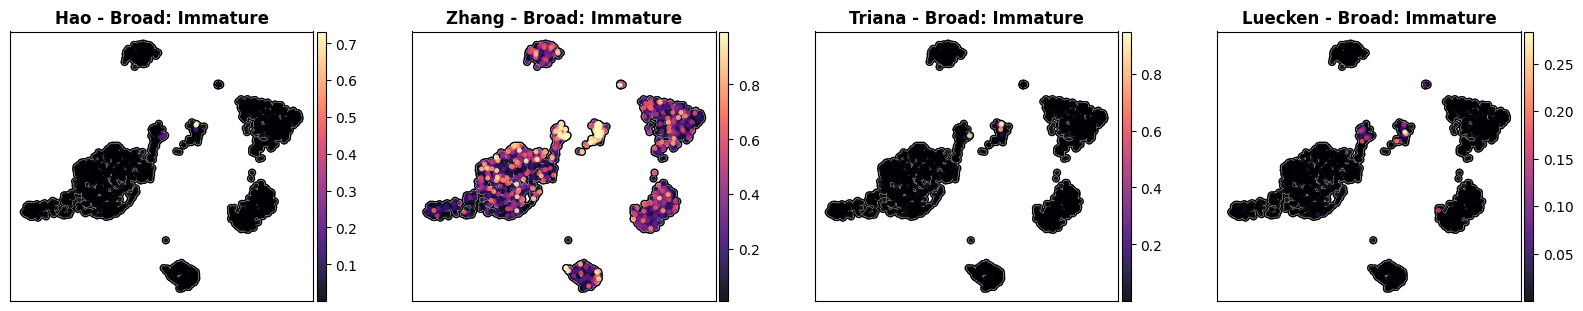

<Figure size 640x480 with 0 Axes>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords

from matplotlib import rc_context
import scanpy as sc
import matplotlib.pyplot as plt

# --- Make sure the three scores exist in pbmc.obs ---
pbmc.obs['Hao.Broad.Immature.predscore'] = PBMC_HD01.protein.row_attrs['Hao.Broad.Immature.predscore']
pbmc.obs['Zhang.Broad.Immature.predscore'] = PBMC_HD01.protein.row_attrs['Zhang.Broad.Immature.predscore']
pbmc.obs['Triana.Broad.Immature.predscore'] = PBMC_HD01.protein.row_attrs['Triana.Broad.Immature.predscore']
pbmc.obs['Luecken.Broad.Immature.predscore'] = PBMC_HD01.protein.row_attrs['Luecken.Broad.Immature.predscore']

# Map internal column names to pretty labels
pretty_names = {
    'Hao.Broad.Immature.predscore': 'Hao - Broad: Immature',
    'Zhang.Broad.Immature.predscore': 'Zhang - Broad: Immature',
    'Triana.Broad.Immature.predscore': 'Triana - Broad: Immature',
    'Luecken.Broad.Immature.predscore': 'Luecken - Broad: Immature'
}

score_cols = list(pretty_names.keys())

with rc_context({"figure.figsize": (4, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color=score_cols,
        add_outline=True,
        cmap="magma",
        frameon=True,
        size=50,
        alpha=0.9,
        title=[pretty_names[c] for c in score_cols],
        return_fig=True,
        show=False
    )

    # Get all axes in the figure
    axs = fig.axes

    for ax in axs:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])

    plt.tight_layout()
    plt.show()

# Save the figure at 300 dpi
plt.savefig(os.path.join(figures_path, "Atlases_Immature_prediction.png"), 
            dpi=300, bbox_inches='tight')

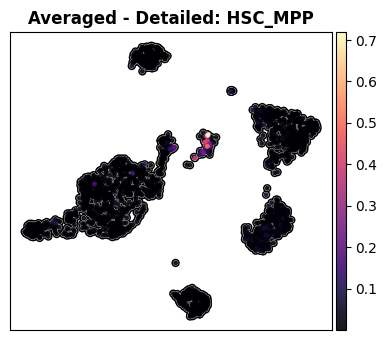

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords

from matplotlib import rc_context
import scanpy as sc
import matplotlib.pyplot as plt

# --- Make sure the three scores exist in pbmc.obs ---
pbmc.obs['Averaged.Broad.Immature.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Broad.Immature.predscore']

# Map internal column names to pretty labels
pretty_names = {
    'Averaged.Broad.Immature.predscore': 'Averaged - Broad: Immature',
}

score_cols = list(pretty_names.keys())

with rc_context({"figure.figsize": (4, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color=score_cols,
        add_outline=True,
        cmap="magma",
        frameon=True,
        size=50,
        alpha=0.9,
        title=[pretty_names[c] for c in score_cols],
        return_fig=True,
        show=False
    )

    # Get all axes in the figure
    axs = fig.axes

    for ax in axs:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])

    plt.tight_layout()
    plt.show()


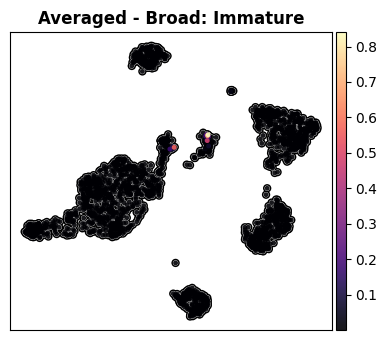

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords

from matplotlib import rc_context
import scanpy as sc
import matplotlib.pyplot as plt

# --- Make sure the three scores exist in pbmc.obs ---
pbmc.obs['Averaged.Broad.Immature.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Broad.Immature.predscore']

# Map internal column names to pretty labels
pretty_names = {
    'Averaged.Broad.Immature.predscore': 'Averaged - Broad: Immature',
}

score_cols = list(pretty_names.keys())

with rc_context({"figure.figsize": (4, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color=score_cols,
        add_outline=True,
        cmap="magma",
        frameon=True,
        size=50,
        alpha=0.9,
        title=[pretty_names[c] for c in score_cols],
        return_fig=True,
        show=False
    )

    # Get all axes in the figure
    axs = fig.axes

    for ax in axs:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])

    plt.tight_layout()
    plt.show()


/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/1358049723.py:62: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



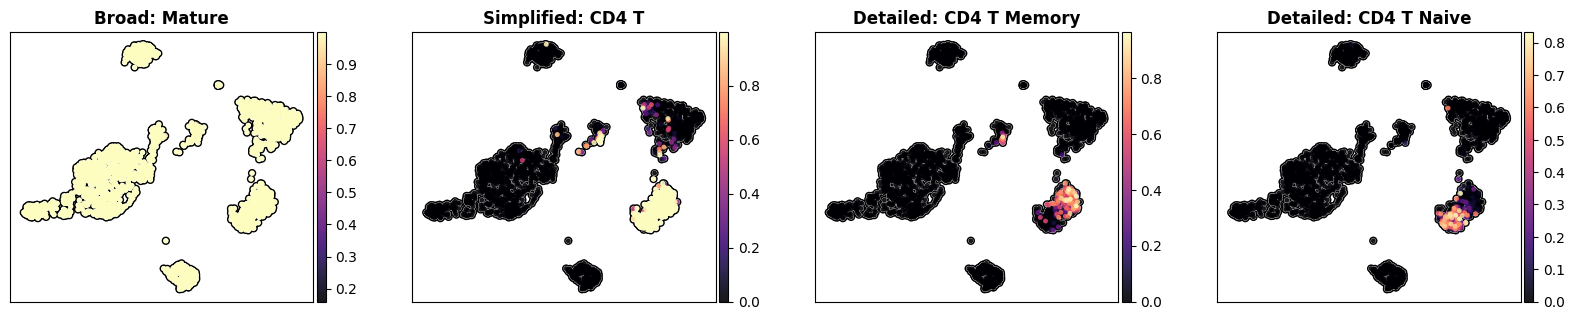

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords

from matplotlib import rc_context
import scanpy as sc
import matplotlib.pyplot as plt

# --- Make sure the three scores exist in pbmc.obs ---
pbmc.obs['Averaged.Broad.Mature.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Broad.Mature.predscore']
pbmc.obs['Averaged.Constrained.Simplified.CD4_T.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Simplified.CD4_T.predscore']
pbmc.obs['Averaged.Constrained.Detailed.CD4_T_Memory.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Detailed.CD4_T_Memory.predscore']
pbmc.obs['Averaged.Constrained.Detailed.CD4_T_Naive.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Detailed.CD4_T_Naive.predscore']

# Map internal column names to pretty labels
pretty_names = {
    'Averaged.Broad.Mature.predscore': 'Broad: Mature',
    'Averaged.Constrained.Simplified.CD4_T.predscore': 'Simplified: CD4 T',
    'Averaged.Constrained.Detailed.CD4_T_Memory.predscore': 'Detailed: CD4 T Memory',
    'Averaged.Constrained.Detailed.CD4_T_Naive.predscore': 'Detailed: CD4 T Naive'
}

score_cols = list(pretty_names.keys())

with rc_context({"figure.figsize": (4, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color=score_cols,
        add_outline=True,
        cmap="magma",
        frameon=True,
        size=50,
        alpha=0.9,
        title=[pretty_names[c] for c in score_cols],
        return_fig=True,
        show=False
    )

    # Get all axes in the figure
    axs = fig.axes

    for ax in axs:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])

    plt.tight_layout()
    plt.show()


/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/3880377006.py:62: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



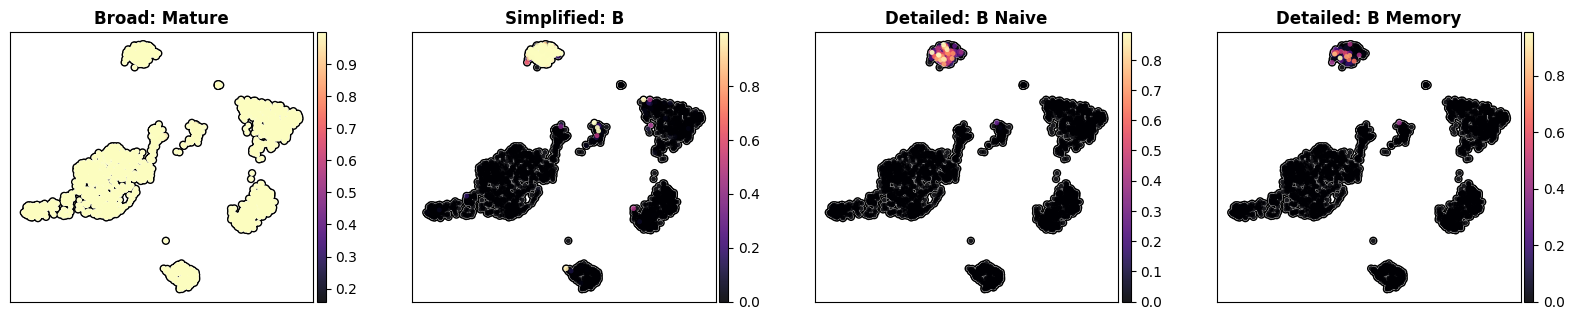

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords

from matplotlib import rc_context
import scanpy as sc
import matplotlib.pyplot as plt

# --- Make sure the three scores exist in pbmc.obs ---
pbmc.obs['Averaged.Broad.Mature.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Broad.Mature.predscore']
pbmc.obs['Averaged.Constrained.Simplified.B.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Simplified.B.predscore']
pbmc.obs['Averaged.Constrained.Detailed.B_Naive.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Detailed.B_Naive.predscore']
pbmc.obs['Averaged.Constrained.Detailed.B_Memory.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Detailed.B_Memory.predscore']

# Map internal column names to pretty labels
pretty_names = {
    'Averaged.Broad.Mature.predscore': 'Broad: Mature',
    'Averaged.Constrained.Simplified.B.predscore': 'Simplified: B',
    'Averaged.Constrained.Detailed.B_Naive.predscore': 'Detailed: B Naive',
    'Averaged.Constrained.Detailed.B_Memory.predscore': 'Detailed: B Memory'
}

score_cols = list(pretty_names.keys())

with rc_context({"figure.figsize": (4, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color=score_cols,
        add_outline=True,
        cmap="magma",
        frameon=True,
        size=50,
        alpha=0.9,
        title=[pretty_names[c] for c in score_cols],
        return_fig=True,
        show=False
    )

    # Get all axes in the figure
    axs = fig.axes

    for ax in axs:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])

    plt.tight_layout()
    plt.show()


/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/369807176.py:60: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



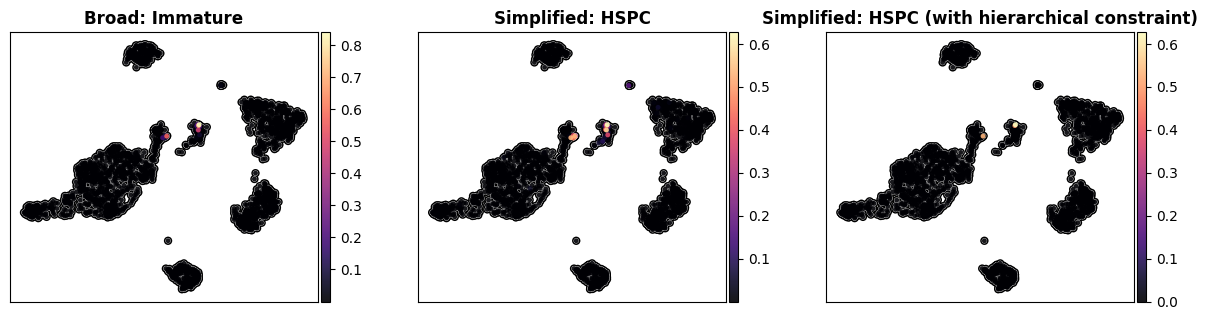

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords

from matplotlib import rc_context
import scanpy as sc
import matplotlib.pyplot as plt

# --- Make sure the three scores exist in pbmc.obs ---
pbmc.obs['Averaged.Broad.Immature.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Broad.Immature.predscore']
pbmc.obs['Averaged.Simplified.HSPC.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Simplified.HSPC.predscore']
pbmc.obs['Averaged.Constrained.Simplified.HSPC.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Simplified.HSPC.predscore']

# Map internal column names to pretty labels
pretty_names = {
    'Averaged.Broad.Immature.predscore': 'Broad: Immature',
    'Averaged.Simplified.HSPC.predscore': 'Simplified: HSPC',
    'Averaged.Constrained.Simplified.HSPC.predscore': 'Simplified: HSPC (with hierarchical constraint)'
}

score_cols = list(pretty_names.keys())

with rc_context({"figure.figsize": (4, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color=score_cols,
        add_outline=True,
        cmap="magma",
        frameon=True,
        size=50,
        alpha=0.9,
        title=[pretty_names[c] for c in score_cols],
        return_fig=True,
        show=False
    )

    # Get all axes in the figure
    axs = fig.axes

    for ax in axs:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])

    plt.tight_layout()
    plt.show()


/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/2587339626.py:60: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



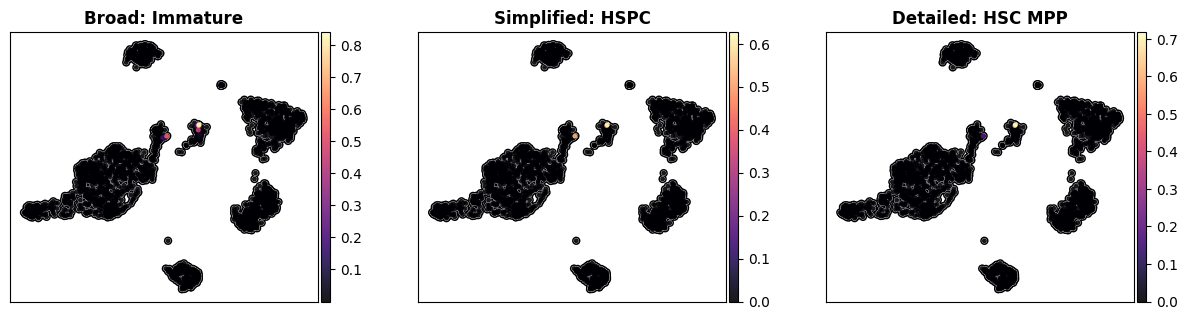

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords

from matplotlib import rc_context
import scanpy as sc
import matplotlib.pyplot as plt

# --- Make sure the three scores exist in pbmc.obs ---
pbmc.obs['Averaged.Broad.Immature.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Broad.Immature.predscore']
pbmc.obs['Averaged.Constrained.Simplified.HSPC.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Simplified.HSPC.predscore']
pbmc.obs['Averaged.Constrained.Detailed.HSC_MPP.predscore'] = PBMC_HD01.protein.row_attrs['Averaged.Constrained.Detailed.HSC_MPP.predscore']

# Map internal column names to pretty labels
pretty_names = {
    'Averaged.Broad.Immature.predscore': 'Broad: Immature',
    'Averaged.Constrained.Simplified.HSPC.predscore': 'Simplified: HSPC',
    'Averaged.Constrained.Detailed.HSC_MPP.predscore': 'Detailed: HSC MPP'
}

score_cols = list(pretty_names.keys())

with rc_context({"figure.figsize": (4, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color=score_cols,
        add_outline=True,
        cmap="magma",
        frameon=True,
        size=50,
        alpha=0.9,
        title=[pretty_names[c] for c in score_cols],
        return_fig=True,
        show=False
    )

    # Get all axes in the figure
    axs = fig.axes

    for ax in axs:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])

    plt.tight_layout()
    plt.show()


## Refining annotations

In [39]:
# Refining labels for PBMC_HD01

n_fix, _, PBMC_HD01 = ep.refine_labels_by_centroid_knn(
    PBMC_HD01,
    label_col="Simplified.Celltype",
    out_col="Simplified.Celltype.Refined"
)

n_fix, _, PBMC_HD01 = ep.refine_labels_by_centroid_knn(
    PBMC_HD01,
    label_col="Detailed.Celltype",
    out_col="Detailed.Celltype.Refined"
)

PBMC_HD01 = ep.mark_small_clusters(PBMC_HD01, "Simplified.Celltype.Refined", min_count=3)
PBMC_HD01 = ep.mark_small_clusters(PBMC_HD01, "Detailed.Celltype.Refined", min_count=3)

# Refining labels for PBMC_HD02

n_fix, _, PBMC_HD02 = ep.refine_labels_by_centroid_knn(
    PBMC_HD02,
    label_col="Simplified.Celltype",
    out_col="Simplified.Celltype.Refined"
)

n_fix, _, PBMC_HD02 = ep.refine_labels_by_centroid_knn(
    PBMC_HD02,
    label_col="Detailed.Celltype",
    out_col="Detailed.Celltype.Refined"
)

PBMC_HD02 = ep.mark_small_clusters(PBMC_HD02, "Simplified.Celltype.Refined", min_count=3)
PBMC_HD02 = ep.mark_small_clusters(PBMC_HD02, "Detailed.Celltype.Refined", min_count=3)

In [40]:
# Suggest cell type identities for PBMC_HD01

ep.suggest_cluster_celltype_identity(
    sample=PBMC_HD01,
    annotation="Simplified.Celltype.Refined")

PBMC_HD01 = ep.suggest_cluster_celltype_identity(
    sample=PBMC_HD01,
    annotation="Detailed.Celltype.Refined", rewrite=True)

# Suggest cell type identities for PBMC_HD02

ep.suggest_cluster_celltype_identity(
    sample=PBMC_HD02,
    annotation="Simplified.Celltype.Refined")

PBMC_HD02 = ep.suggest_cluster_celltype_identity(
    sample=PBMC_HD02,
    annotation="Detailed.Celltype.Refined", rewrite=True)

## Exploring annotations in PBMC - HD01

/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/3188303555.py:57: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



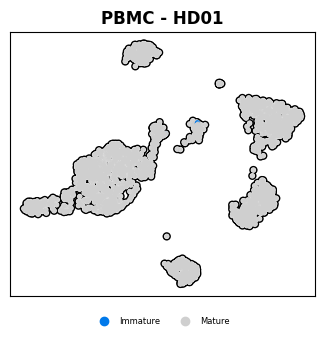

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])               # (n_cells, 2)
labels = np.asarray(PBMC_HD01.protein.row_attrs['Broad.Celltype']) # (n_cells,)

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords
pbmc.obs['clusters'] = pd.Categorical(labels)     # must be categorical for nice legends

# --- Custom palette (match your label names) ---
custom_palette = {
    'Immature': "#0079ea",
    'Mature': "#CFCFCF"
}
cats = list(pbmc.obs['clusters'].cat.categories)
palette = [custom_palette.get(c, '#cccccc') for c in cats]  # grey fallback

# --- Plot with Scanpy + outlines (like your example) ---
with rc_context({"figure.figsize": (3.35, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color="clusters",
        palette=palette,
        add_outline=True,
        legend_fontsize=6,
        legend_fontoutline=2,
        frameon=True,
        title="PBMC - HD01",
        size=50,
        alpha=0.9,
        return_fig=True,   # so we get the figure handle
        show=False,
    )

    for ax in fig.axes:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])

        # Move legend outside below plot
        leg = ax.get_legend()
        if leg is not None:
            ax.legend(
                handles=leg.legendHandles,
                labels=[t.get_text() for t in leg.get_texts()],
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),  # below plot
                ncol=len(palette),            # all in one row
                fontsize=6,
                frameon=False
            )

    plt.tight_layout()
    plt.show()



/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/2923263561.py:66: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



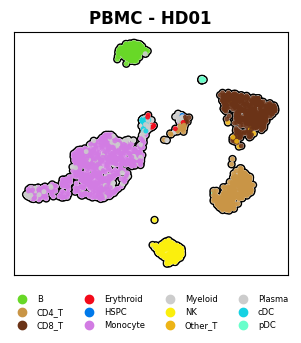

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])               # (n_cells, 2)
labels = np.asarray(PBMC_HD01.protein.row_attrs['Simplified.Celltype.Refined']) # (n_cells,)

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords
pbmc.obs['clusters'] = pd.Categorical(labels)     # must be categorical for nice legends

# --- Custom palette (match your label names) ---
custom_palette = {
    'HSPC': '#0079ea',
    'cDC': "#16D2E3",
    'pDC': "#69FFCB",
    'Monocyte': '#D27CE3',
    'Other_T': "#EDB416",
    'Erythroid': "#F30A1A",
    'CD4_T': '#C99546',
    'CD8_T': "#6B3317",
    'NK': "#FBEF0D",
    'B': '#68D827',
    'Small': "#292929"
}
cats = list(pbmc.obs['clusters'].cat.categories)
palette = [custom_palette.get(c, '#cccccc') for c in cats]  # grey fallback

# --- Plot with Scanpy + outlines (like your example) ---
with rc_context({"figure.figsize": (3.30, 3.55)}):
    fig = sc.pl.umap(
        pbmc,
        color="clusters",
        palette=palette,
        add_outline=True,
        legend_fontsize=6,
        legend_fontoutline=2,
        frameon=True,
        title="PBMC - HD01",
        size=50,
        alpha=0.9,
        return_fig=True,   # so we get the figure handle
        show=False,
    )

    for ax in fig.axes:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])

        # Move legend outside below plot
        leg = ax.get_legend()
        if leg is not None:
            ax.legend(
                handles=leg.legendHandles,
                labels=[t.get_text() for t in leg.get_texts()],
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),  # below plot
                ncol=4,            # all in one row
                fontsize=6,
                frameon=False
            )

    plt.tight_layout()
    plt.show()



/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/4066065854.py:81: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



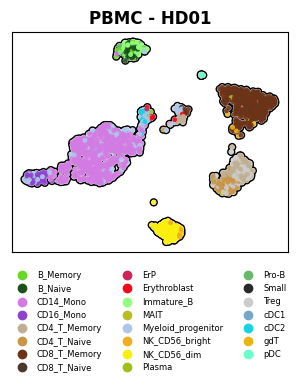

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])               # (n_cells, 2)
labels = np.asarray(PBMC_HD01.protein.row_attrs['Detailed.Celltype.Refined']) # (n_cells,)

pbmc = AnnData(X=PBMC_HD01.protein.layers['Scaled_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords
pbmc.obs['clusters'] = pd.Categorical(labels)     # must be categorical for nice legends

# --- Custom palette (match your label names) ---
custom_palette = {
    'B_Memory': "#68D827",           # from your original
    'B_Naive': '#1C511D',            # from your original
    'CD14_Mono': "#D27CE3",          # from your original
    'CD16_Mono': "#8D43CD",          # from your original
    'CD4_T_Memory': "#C1AF93",       # from your original
    'CD4_T_Naive': "#C99546",        # from your original
    'CD8_T_Memory': "#6B3317",       # from your original
    'CD8_T_Naive': "#4D382E",        # new
    'ErP': "#D1235A",                # new
    'Erythroblast': "#F30A1A",       # new
    'GMP': "#C5E4FF",                # new
    'HSC_MPP': '#0079ea',            # from your original
    'Immature_B': "#91FF7B",         # new
    'LMPP': "#17BECF",               # new
    'MAIT': "#BCBD22",               # new
    'Myeloid_progenitor': "#AEC7E8", # new
    'NK_CD56_bright': "#F3AC1F",     # new
    'NK_CD56_dim': "#FBEF0D",        # from your original
    'Plasma': "#9DC012",             # new
    'Pro-B': "#66BB6A",              # new
    'Small': "#292929",              # new
    'cDC1': "#76A7CB",               # new
    'cDC2': "#16D2E3",               # from your original
    'gdT': "#EDB416",                # from your original
    'pDC': "#69FFCB"                 # from your original
}

cats = list(pbmc.obs['clusters'].cat.categories)
palette = [custom_palette.get(c, '#cccccc') for c in cats]  # grey fallback

# --- Plot with Scanpy + outlines (like your example) ---
with rc_context({"figure.figsize": (3.3, 4)}):
    fig = sc.pl.umap(
        pbmc,
        color="clusters",
        palette=palette,
        add_outline=True,
        legend_fontsize=6,
        legend_fontoutline=2,
        frameon=True,
        title="PBMC - HD01",
        size=50,
        alpha=0.9,
        return_fig=True,   # so we get the figure handle
        show=False,
    )

    for ax in fig.axes:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])

        # Move legend outside below plot
        leg = ax.get_legend()
        if leg is not None:
            ax.legend(
                handles=leg.legendHandles,
                labels=[t.get_text() for t in leg.get_texts()],
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),  # below plot
                ncol=3,            # all in one row
                fontsize=6,
                frameon=False
            )

    plt.tight_layout()
    plt.show()



/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/2010349025.py:47: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



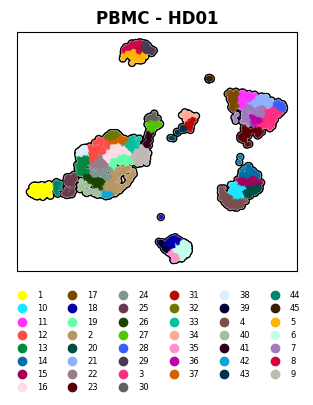

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])               # (n_cells, 2)
labels = np.asarray(PBMC_HD01.protein.row_attrs['label']) # (n_cells,)

pbmc = AnnData(X=PBMC_HD01.protein.layers['Normalized_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords
pbmc.obs['clusters'] = pd.Categorical(labels)     # must be categorical for nice legends
# --- Plot with Scanpy + outlines (like your example) ---
with rc_context({"figure.figsize": (3.4, 4.2)}):
    fig = sc.pl.umap(
        pbmc,
        color="clusters",
        add_outline=True,
        legend_fontsize=6,
        legend_fontoutline=2,
        frameon=True,
        title="PBMC - HD01",
        size=50,
        alpha=0.9,
        return_fig=True,   # so we get the figure handle
        show=False,
    )

    for ax in fig.axes:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])

        # Move legend outside below plot
        leg = ax.get_legend()
        if leg is not None:
            ax.legend(
                handles=leg.legendHandles,
                labels=[t.get_text() for t in leg.get_texts()],
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),  # below plot
                ncol=6,            # all in one row
                fontsize=6,
                frameon=False
            )

    plt.tight_layout()
    plt.show()



/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/3730684815.py:82: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



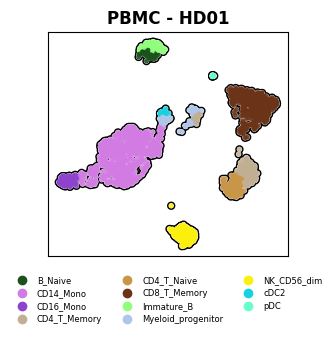

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD01.protein.row_attrs['umap'])               # (n_cells, 2)
labels = np.asarray(PBMC_HD01.protein.row_attrs['annotated_clusters']) # (n_cells,)

pbmc = AnnData(X=PBMC_HD01.protein.layers['Normalized_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD01.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords
pbmc.obs['clusters'] = pd.Categorical(labels)     # must be categorical for nice legends


# --- Custom palette (match your label names) ---
custom_palette = {
    'B_Memory': "#68D827",           # from your original
    'B_Naive': '#1C511D',            # from your original
    'CD14_Mono': "#D27CE3",          # from your original
    'CD16_Mono': "#8D43CD",          # from your original
    'CD4_T_Memory': "#C1AF93",       # from your original
    'CD4_T_Naive': "#C99546",        # from your original
    'CD8_T_Memory': "#6B3317",       # from your original
    'CD8_T_Naive': "#4D382E",        # new
    'ErP': "#D1235A",                # new
    'Erythroblast': "#F30A1A",       # new
    'GMP': "#C5E4FF",                # new
    'HSC_MPP': '#0079ea',            # from your original
    'Immature_B': "#91FF7B",         # new
    'LMPP': "#17BECF",               # new
    'MAIT': "#BCBD22",               # new
    'Myeloid_progenitor': "#AEC7E8", # new
    'NK_CD56_bright': "#F3AC1F",     # new
    'NK_CD56_dim': "#FBEF0D",        # from your original
    'Plasma': "#9DC012",             # new
    'Pro-B': "#66BB6A",              # new
    'Small': "#292929",              # new
    'cDC1': "#76A7CB",               # new
    'cDC2': "#16D2E3",               # from your original
    'gdT': "#EDB416",                # from your original
    'pDC': "#69FFCB"                 # from your original
}

cats = list(pbmc.obs['clusters'].cat.categories)
palette = [custom_palette.get(c, '#cccccc') for c in cats]  # grey fallback

# --- Plot with Scanpy + outlines (like your example) ---
with rc_context({"figure.figsize": (3.30, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color="clusters",
        add_outline=True,
        palette=palette,
        legend_fontsize=6,
        legend_fontoutline=2,
        frameon=True,
        title="PBMC - HD01",
        size=50,
        alpha=0.9,
        return_fig=True,   # so we get the figure handle
        show=False,
    )

    for ax in fig.axes:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])

        # Move legend outside below plot
        leg = ax.get_legend()
        if leg is not None:
            ax.legend(
                handles=leg.legendHandles,
                labels=[t.get_text() for t in leg.get_texts()],
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),  # below plot
                ncol=3,            # all in one row
                fontsize=6,
                frameon=False
            )

    plt.tight_layout()
    plt.show()



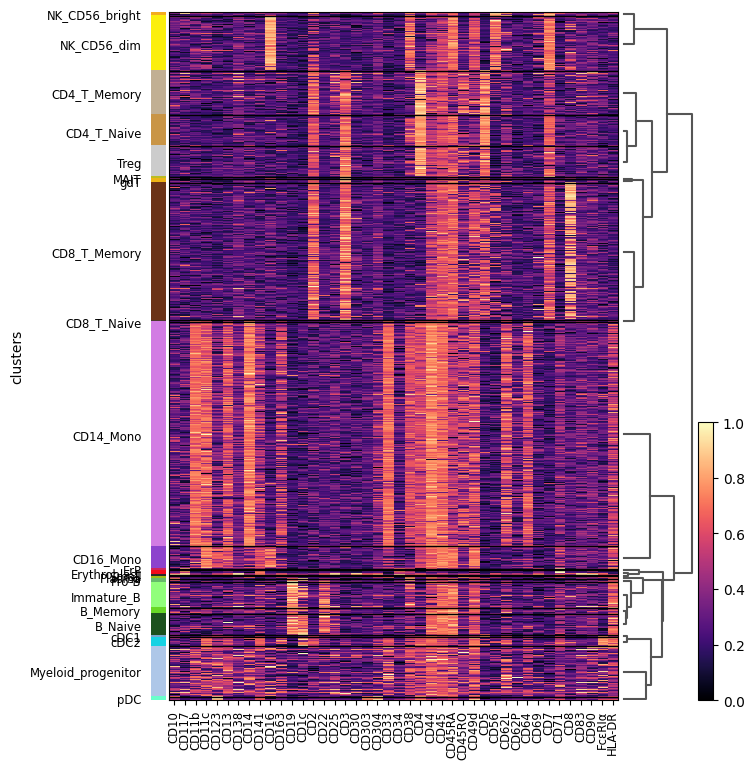

In [54]:
# Make sure categories are in the right order
cats = list(pbmc.obs['clusters'].cat.categories)
palette = [custom_palette.get(c, '#cccccc') for c in cats]

# Assign palette to the AnnData object for 'clusters'
pbmc.uns['clusters_colors'] = palette

# Now plot the heatmap — no 'palette' argument needed
all_genes = pbmc.var_names.tolist()
genes_to_plot = all_genes  # or subset for readability

sc.pl.heatmap(
    pbmc,
    var_names=genes_to_plot,
    groupby="clusters",
    use_raw=False,
    cmap="magma",
    dendrogram=True,
    standard_scale="var",  # z-score each gene across clusters
    figsize=(7.25, 9)
)


In [47]:
PBMC_HD01.protein.row_attrs

{'barcode': array(['AACAACCTACAATCATAC', 'AACAACTGGTGATACCGT', 'AACAACTGGTGTCGTGAG',
        ..., 'TTGTCAACCGATGCTCCT', 'TTGTTAGAGTATACCACT',
        'TTGTTAGAGTTCGCATCC'], dtype=object),
 'label': array(['37', '35', '30', ..., '3', '34', '11'], dtype=object),
 'sample_name': array(['Sample 1', 'Sample 1', 'Sample 1', ..., 'Sample 1', 'Sample 1',
        'Sample 1'], dtype=object),
 'umap': array([[ -3.152337  ,   1.1386538 ],
        [  0.65788746, -10.317387  ],
        [ -1.3771243 ,   3.2831466 ],
        ...,
        [  7.3962107 ,   3.0229216 ],
        [  1.4615576 ,   3.522924  ],
        [  5.7761564 ,   5.5204163 ]], dtype=float32),
 'pca': array([[-0.02397133,  0.00039214, -0.00181046, ...,  0.02426448,
         -0.00737591, -0.02752437],
        [ 0.01781499,  0.01697718, -0.01003601, ...,  0.02298067,
         -0.04654263, -0.0180832 ],
        [-0.00706501,  0.00758726,  0.00495712, ..., -0.01576131,
          0.03216651, -0.01892142],
        ...,
        [ 0.02216934, -

In [56]:
PBMC_HD01.protein.signaturemap('Normalized_reads',
                           splitby='Detailed.Celltype')

## Exploring annotations in PBMC - HD02

/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/1580928225.py:47: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



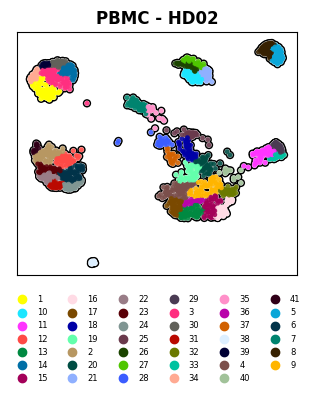

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD02.protein.row_attrs['umap'])               # (n_cells, 2)
labels = np.asarray(PBMC_HD02.protein.row_attrs['label']) # (n_cells,)

pbmc = AnnData(X=PBMC_HD02.protein.layers['Normalized_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD02.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords
pbmc.obs['clusters'] = pd.Categorical(labels)     # must be categorical for nice legends
# --- Plot with Scanpy + outlines (like your example) ---
with rc_context({"figure.figsize": (3.4, 4.1)}):
    fig = sc.pl.umap(
        pbmc,
        color="clusters",
        add_outline=True,
        legend_fontsize=6,
        legend_fontoutline=2,
        frameon=True,
        title="PBMC - HD02",
        size=50,
        alpha=0.9,
        return_fig=True,   # so we get the figure handle
        show=False,
    )

    for ax in fig.axes:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])

        # Move legend outside below plot
        leg = ax.get_legend()
        if leg is not None:
            ax.legend(
                handles=leg.legendHandles,
                labels=[t.get_text() for t in leg.get_texts()],
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),  # below plot
                ncol=6,            # all in one row
                fontsize=6,
                frameon=False
            )

    plt.tight_layout()
    plt.show()



/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_14821/3669816857.py:82: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



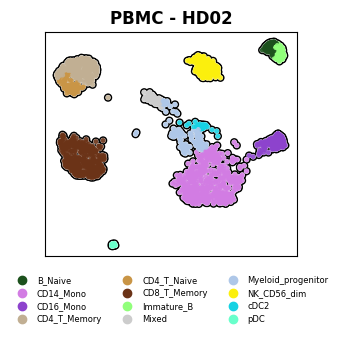

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

# --- Build a minimal AnnData from Mosaic arrays ---
coords = np.asarray(PBMC_HD02.protein.row_attrs['umap'])               # (n_cells, 2)
labels = np.asarray(PBMC_HD02.protein.row_attrs['annotated_clusters']) # (n_cells,)

pbmc = AnnData(X=PBMC_HD02.protein.layers['Normalized_reads'])  # dummy X; we only need obs/obsm for plotting
df_protein = PBMC_HD02.protein.get_attribute('Normalized_reads', constraint='row+col')
pbmc.obs_names = df_protein.index
pbmc.var_names = df_protein.columns
pbmc.obsm['X_umap'] = coords
pbmc.obs['clusters'] = pd.Categorical(labels)     # must be categorical for nice legends


# --- Custom palette (match your label names) ---
custom_palette = {
    'B_Memory': "#68D827",           # from your original
    'B_Naive': '#1C511D',            # from your original
    'CD14_Mono': "#D27CE3",          # from your original
    'CD16_Mono': "#8D43CD",          # from your original
    'CD4_T_Memory': "#C1AF93",       # from your original
    'CD4_T_Naive': "#C99546",        # from your original
    'CD8_T_Memory': "#6B3317",       # from your original
    'CD8_T_Naive': "#4D382E",        # new
    'ErP': "#D1235A",                # new
    'Erythroblast': "#F30A1A",       # new
    'GMP': "#C5E4FF",                # new
    'HSC_MPP': '#0079ea',            # from your original
    'Immature_B': "#91FF7B",         # new
    'LMPP': "#17BECF",               # new
    'MAIT': "#BCBD22",               # new
    'Myeloid_progenitor': "#AEC7E8", # new
    'NK_CD56_bright': "#F3AC1F",     # new
    'NK_CD56_dim': "#FBEF0D",        # from your original
    'Plasma': "#9DC012",             # new
    'Pro-B': "#66BB6A",              # new
    'Small': "#292929",              # new
    'cDC1': "#76A7CB",               # new
    'cDC2': "#16D2E3",               # from your original
    'gdT': "#EDB416",                # from your original
    'pDC': "#69FFCB"                 # from your original
}

cats = list(pbmc.obs['clusters'].cat.categories)
palette = [custom_palette.get(c, '#cccccc') for c in cats]  # grey fallback

# --- Plot with Scanpy + outlines (like your example) ---
with rc_context({"figure.figsize": (3.4, 3.5)}):
    fig = sc.pl.umap(
        pbmc,
        color="clusters",
        add_outline=True,
        palette=palette,
        legend_fontsize=6,
        legend_fontoutline=2,
        frameon=True,
        title="PBMC - HD02",
        size=50,
        alpha=0.9,
        return_fig=True,   # so we get the figure handle
        show=False,
    )

    for ax in fig.axes:
        # Bold titles
        ax.set_title(ax.get_title(), fontweight='bold')
        # Remove axis labels and ticks
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])

        # Move legend outside below plot
        leg = ax.get_legend()
        if leg is not None:
            ax.legend(
                handles=leg.legendHandles,
                labels=[t.get_text() for t in leg.get_texts()],
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),  # below plot
                ncol=3,            # all in one row
                fontsize=6,
                frameon=False
            )

    plt.tight_layout()
    plt.show()



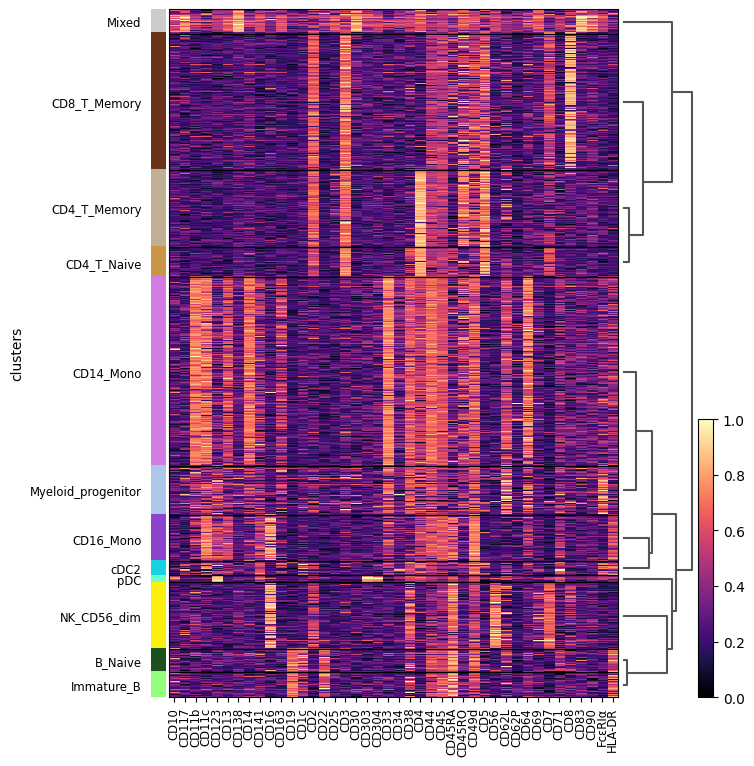

In [51]:
# Make sure categories are in the right order
cats = list(pbmc.obs['clusters'].cat.categories)
palette = [custom_palette.get(c, '#cccccc') for c in cats]

# Assign palette to the AnnData object for 'clusters'
pbmc.uns['clusters_colors'] = palette

# Now plot the heatmap — no 'palette' argument needed
all_genes = pbmc.var_names.tolist()
genes_to_plot = all_genes  # or subset for readability

sc.pl.heatmap(
    pbmc,
    var_names=genes_to_plot,
    groupby="clusters",
    use_raw=False,
    cmap="magma",
    dendrogram=True,
    standard_scale="var",  # z-score each gene across clusters
    figsize=(7.25, 9)
)




In [52]:
PBMC_HD02.protein.signaturemap('Normalized_reads',
                           splitby='Detailed.Celltype.Refined')